# Applied Machine Learning

This notebook compiles standard methods for classification and regression into one notebook. The hope is that this notebook will be a good template to begin projects and reduce repetitive work.

![xkcd](https://imgs.xkcd.com/comics/machine_learning.png)

https://xkcd.com/1838/

## Dependencies

In [916]:
# installations
%pip install lightgbm
%pip install xgboost

In [917]:
# standard DS / ML libraries
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [918]:
# data viz
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
# make sure viz shows up in the notebook
%matplotlib inline
import seaborn as sns

In [919]:
# regression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC

In [920]:
# classification
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier

In [921]:
# model performance & iterative improvement
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer, roc_curve, precision_recall_curve,  roc_auc_score, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from time import perf_counter
from hyperopt import hp, tpe, Trials, space_eval
from hyperopt.fmin import fmin
from lightgbm.callback import early_stopping

## Set Up

In [922]:
class BaseDataset:
  """
  Basic methods to handle loading and splitting data for experiments
  """

  def _load_data(self):
    """
    _load_data is a method that expects to be overwritten by the class extension
    :return: error, if not implemented in the extended class
    """
    raise NotImplementedError

  def split_data_and_label(self, train_data, label_column_name, id_column_name=None):
    """
    split_data_and_label takes a training set and returns data split from labels

    :param train_data: a training set without labels
    :param train_label: a set of labels detached from training data
    :return: train, validate, and test data
    """
    if id_column_name is not None:
      del train_data[id_column_name]
    
    train_label = train_data[label_column_name]
    del train_data[label_column_name]
    
    return train_data, train_label   

  def _split_data(self, train_data, train_label, sampling_method):
    """
    shuffle_split exploits the behavior of sklearn's train test split to split the data into train, validate, test in a standard 80 / 10 / 10 pattern

    :param train_data: a training set without labels
    :param train_label: a set of labels detached from training data
    :return: train, validate, and test data
    """ 


  def _subsample(self, train_data, train_label, number_of_samples):
    """
    stratified_split divides data into train / validate / test while maintaining the percentages of each class

    :param train_data: a training set without labels
    :param train_label: a set of labels detached from training data
    :return: train, validate, and test data
    """ 
    rs = np.random.RandomState(42)
    indices0 = rs.choice(np.where(train_label == 0)[0], number_of_samples, replace=False)
    indices1 = rs.choice(np.where(train_label == 1)[0], number_of_samples, replace=False)
    indices = np.concatenate([indices0, indices1])
    train_data = train_data.iloc[indices]
    train_label = train_label.iloc[indices]
    # train_data = train_data.reset_index(inplace=True)
    # train_label = train_label.reset_index(inplace=True)
    return train_data, train_label
    
  

  def get_train_val_test_data(self, train_data, train_label, values_to_stratify_by=None):
    """
    get_train_val_test_data exploits the behavior of sklearn's train test split to split the data into train, validate, test in a standard 80 / 10 / 10 pattern

    :param train_data: a training set without labels
    :param train_label: a set of labels detached from training data
    :return: train, validate, and test data
    """ 

    X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(
        train_data, train_label, test_size=0.2, random_state=42, shuffle=True, stratify=values_to_stratify_by)
    X_val, X_test, y_val, y_test = train_test_split(
        X_test_and_val, y_test_and_val, test_size=0.5, random_state=42, shuffle=True, stratify=values_to_stratify_by)
    
    return dict(X_train=X_train, y_train=y_train,
                X_val=X_val, y_val=y_val,
                X_test=X_test, y_test=y_test)
    

  def nan_check(self, data):
    """
    nan_check is a method that reports missing data by percentage

    :param data: a dataframe containing training data
    :return: a dataframe containing a report of missing data
    """ 

    total = data.isnull().sum().sort_values(ascending=False)
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
    return missing_data

## Data

In [923]:
class ExperimentDataset(BaseDataset):
  
  def _load_data(self, filepath):
    """
    _load_data gets data from source, then lower cases all column names

    :param filepath: path where the data is located
    :return: train, validate, and test data
    """ 
    df = pd.read_csv(filepath)
    df = df.rename(columns=str.lower)
    return df

dataset = ExperimentDataset()
training_label = 'training_label_column_name'

In [924]:
# https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data?resource=download
eda_data = dataset._load_data('./penguins_size.csv')

In [925]:
eda_data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


## Exploratory Data Analysis

In [926]:
eda_data.shape

(344, 7)

In [927]:
eda_data.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


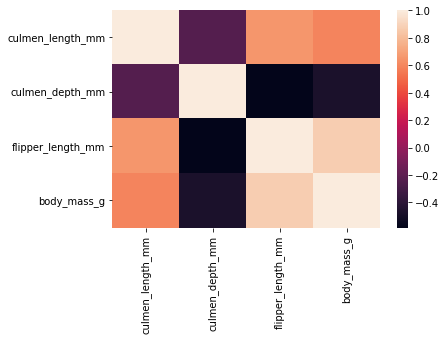

In [928]:
corr = eda_data.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

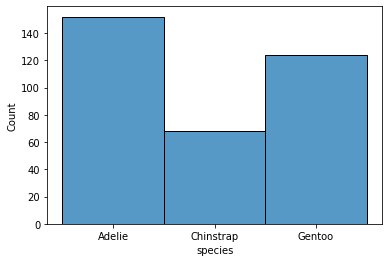

In [929]:
sns.histplot(data=eda_data, x="species")

In [930]:
# profile = ProfileReport(eda_data)
# profile.to_widgets()

## Data Cleaning && Feature Engineering

In [931]:
data = eda_data

### NOTE WHICH COLUMNS ARE LABELS BEFORE PROCEEDING!

In [932]:
data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [933]:
binned_label = 'species'
continuous_label = 'body_mass_g'

### Differentiate between numeric and categorical data

In [934]:
column_list = list(data.columns)
column_list_without_label = column_list.remove(binned_label)
numeric_column_names = data.select_dtypes(include=np.number).columns.tolist()
categorical_column_names = data.select_dtypes(exclude=np.number).columns.tolist()

In [935]:
categorical_column_names.remove(binned_label)

### Handle Outliers

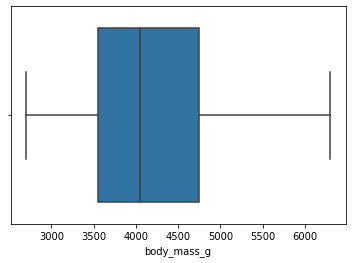

In [936]:
ax = sns.boxplot(x=data[continuous_label])

#### Visualize Outliers

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

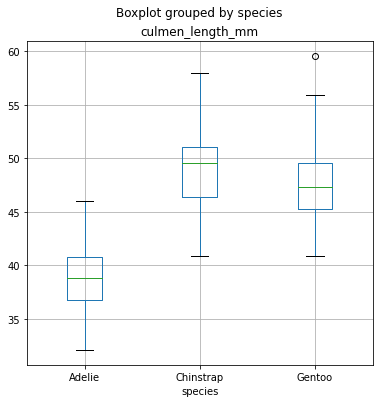

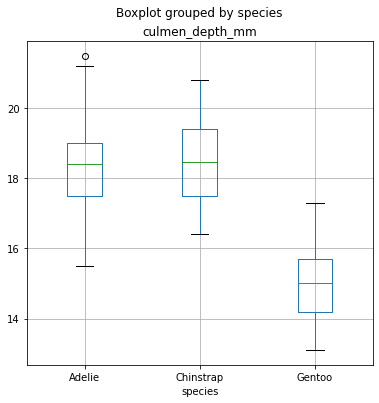

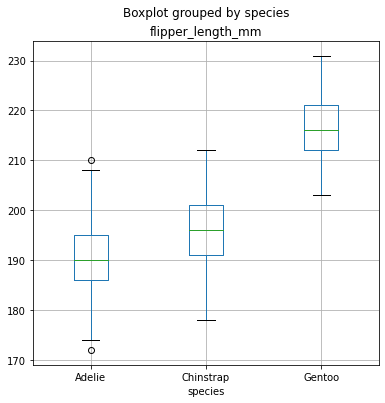

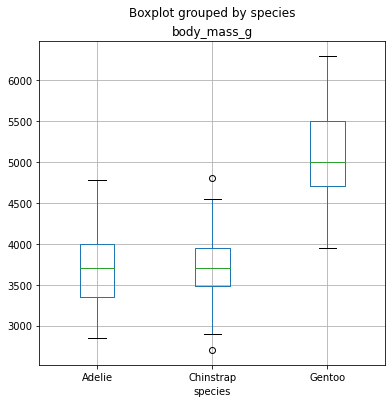

In [937]:
for col in numeric_column_names:
    data.boxplot(column=col, by=binned_label, figsize=(6,6))
    plt.title(col)
plt.show()

#### By Standard Deviation

In [938]:
# Dropping the outlier rows with standard deviation above a factor
factor = 2
upper_lim = data[continuous_label].mean () + data[continuous_label].std () * factor
lower_lim = data[continuous_label].mean () - data[continuous_label].std () * factor

data = data[(data[continuous_label] < upper_lim) & (data[continuous_label] > lower_lim)]

#### By Percentile

In [939]:
#Dropping the outlier rows with Percentiles

# upper_lim = data['column'].quantile(.95)
# lower_lim = data['column'].quantile(.05)

# data = data[(data['column'] < upper_lim) & (data['column'] > lower_lim)]

#### Check Outliers After Data Transformation

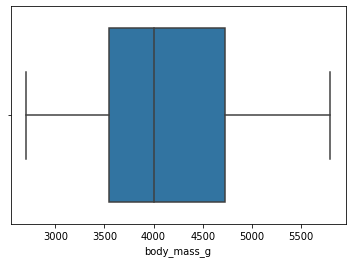

In [940]:
ax = sns.boxplot(x=data[continuous_label])

### Binning

 #### Numerical

In [941]:
# data['bin'] = pd.cut(data['value'], bins=[0,30,70,100], labels=["Low", "Mid", "High"])

#### Categorical

In [942]:
# conditions = [
#     data['Country'].str.contains('Spain'),
#     data['Country'].str.contains('Italy'),
#     data['Country'].str.contains('Chile'),
#     data['Country'].str.contains('Brazil')]

# choices = ['Europe', 'Europe', 'South America', 'South America']

# data['Continent'] = np.select(conditions, choices, default='Other')

### Imputation / Handling Missing Values

In [943]:
dataset.nan_check(data)

,Total,%
sex,8,2.4
species,0,0.0
island,0,0.0
culmen_length_mm,0,0.0
culmen_depth_mm,0,0.0
flipper_length_mm,0,0.0
body_mass_g,0,0.0


#### Drop Option

##### Above Threshold

In [944]:
# threshold = 0.7
#Dropping columns with missing value rate higher than threshold
# data = data[data.columns[data.isnull().mean() < threshold]]

#Dropping rows with missing value rate higher than threshold
# data = data.loc[data.isnull().mean(axis=1) < threshold]

##### All Nulls

In [945]:
data = data.dropna()

#### Fill Option

##### Numeric: Fill with Zero

In [946]:
# filling all missing values with 0
# data = data.fillna(0)

##### Numeric: Fill with Median

In [947]:
# filling missing values with medians of the columns
# data = data.fillna(data.median())

String: Fill with Categorical Most Common Value

#### Check Missing Values Again After Data Transformation

In [948]:
dataset.nan_check(data)

,Total,%
species,0,0.0
island,0,0.0
culmen_length_mm,0,0.0
culmen_depth_mm,0,0.0
flipper_length_mm,0,0.0
body_mass_g,0,0.0
sex,0,0.0


### One-Hot Encoding

In [949]:
one_hotted_columns = pd.get_dummies(data[categorical_column_names])

data = data.drop(columns=categorical_column_names)

data = pd.concat([data, one_hotted_columns], axis=1)

data

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_.,sex_FEMALE,sex_MALE
0,Adelie,39.1,18.7,181.0,3750.0,0,0,1,0,0,1
1,Adelie,39.5,17.4,186.0,3800.0,0,0,1,0,1,0
2,Adelie,40.3,18.0,195.0,3250.0,0,0,1,0,1,0
4,Adelie,36.7,19.3,193.0,3450.0,0,0,1,0,1,0
5,Adelie,39.3,20.6,190.0,3650.0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0,1,0,0,0,1,0
340,Gentoo,46.8,14.3,215.0,4850.0,1,0,0,0,1,0
341,Gentoo,50.4,15.7,222.0,5750.0,1,0,0,0,0,1
342,Gentoo,45.2,14.8,212.0,5200.0,1,0,0,0,1,0


#### Check Column List After One Hot Encoding Categorical Data

In [950]:
data.columns

Index(['species', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'island_Biscoe', 'island_Dream', 'island_Torgersen',
       'sex_.', 'sex_FEMALE', 'sex_MALE'],
      dtype='object')

In [951]:
data.head()

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_.,sex_FEMALE,sex_MALE
0,Adelie,39.1,18.7,181.0,3750.0,0,0,1,0,0,1
1,Adelie,39.5,17.4,186.0,3800.0,0,0,1,0,1,0
2,Adelie,40.3,18.0,195.0,3250.0,0,0,1,0,1,0
4,Adelie,36.7,19.3,193.0,3450.0,0,0,1,0,1,0
5,Adelie,39.3,20.6,190.0,3650.0,0,0,1,0,0,1


### Splitting

##### Strings

In [952]:
# data.full_name
#Extracting first names
# data.full_name.str.split(" ").map(lambda x: x[0])
#Extracting last names
# data.full_name.str.split(" ").map(lambda x: x[-1])

##### Numbers

In [953]:
# find a method that splits at the decimal or rounds

### Other String Cleaning Methods (e.g. regex)

### Scaling

##### Normalization of a Single Column

In [954]:
for column in numeric_column_names:
  data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

##### Standardization of a Single Column

In [955]:
# data['standardized_label'] = (data[continuous_label] - data[continuous_label].mean()) / data[continuous_label].std()

##### Pipelines

Normally scaling is done in the context of a pipeline. This can be combined with training to streamline. Here's an example below for reference.

In [956]:
# # https://scikit-learn.org/stable/modules/preprocessing.html
# # https://www.kaggle.com/code/satishgunjal/binary-multiclass-classification-using-sklearn/notebook#Multiclass-Classification

# # Define preprocessing for numeric columns (scale them)
# feature_columns = [0,1,2,3]
# feature_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
#     ])

# # Create preprocessing steps
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('preprocess', feature_transformer, feature_columns)])

# # Create training pipeline
# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('regressor', SVC(probability=True))])


# # fit the pipeline to train a linear regression model on the training set
# multi_model = pipeline.fit(x_penguin_train, y_penguin_train)
# print (multi_model)

### Date Handling

In [957]:
# #Transform string to date
# data['date'] = pd.to_datetime(data.date, format="%d-%m-%Y")

# #Extracting Year
# data['year'] = data['date'].dt.year

# #Extracting Month
# data['month'] = data['date'].dt.month

# #Extracting passed years since the date
# data['passed_years'] = date.today().year - data['date'].dt.year

# #Extracting passed months since the date
# data['passed_months'] = (date.today().year - data['date'].dt.year) * 12 + date.today().month - data['date'].dt.month

# #Extracting the weekday name of the date
# data['day_name'] = data['date'].dt.day_name()

### PII & IDs

In [958]:
# TO DO:

### Drop Columns as Needed

In [959]:
columns_to_drop = ['sex_.']

data = data.drop(columns=columns_to_drop)

### Sanity Check Before Train Test Split

In [960]:
data.columns

Index(['species', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'island_Biscoe', 'island_Dream', 'island_Torgersen',
       'sex_FEMALE', 'sex_MALE'],
      dtype='object')

In [961]:
data.head()

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE
0,Adelie,0.270270,0.666667,0.152542,0.338710,0,0,1,0,1
1,Adelie,0.285714,0.511905,0.237288,0.354839,0,0,1,1,0
2,Adelie,0.316602,0.583333,0.389831,0.177419,0,0,1,1,0
4,Adelie,0.177606,0.738095,0.355932,0.241935,0,0,1,1,0
5,Adelie,0.277992,0.892857,0.305085,0.306452,0,0,1,0,1


## Split Data into Training, Validation, and Test Sets

In [962]:
train_data, train_label = dataset.split_data_and_label(data, binned_label)

In [963]:
train_data

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE
0,0.270270,0.666667,0.152542,0.338710,0,0,1,0,1
1,0.285714,0.511905,0.237288,0.354839,0,0,1,1,0
2,0.316602,0.583333,0.389831,0.177419,0,0,1,1,0
4,0.177606,0.738095,0.355932,0.241935,0,0,1,1,0
5,0.277992,0.892857,0.305085,0.306452,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
338,0.583012,0.071429,0.711864,0.717742,1,0,0,1,0
340,0.567568,0.142857,0.728814,0.693548,1,0,0,1,0
341,0.706564,0.309524,0.847458,0.983871,1,0,0,0,1
342,0.505792,0.202381,0.677966,0.806452,1,0,0,1,0


In [964]:
train_label

0      Adelie
1      Adelie
2      Adelie
4      Adelie
5      Adelie
        ...  
338    Gentoo
340    Gentoo
341    Gentoo
342    Gentoo
343    Gentoo
Name: species, Length: 325, dtype: object

In [965]:
values_to_stratify_by = eda_data.species.unique()
values_to_stratify_by

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [966]:
experiment_data = dataset.get_train_val_test_data(train_data, train_label)

In [967]:
X_train = experiment_data['X_train']
X_val = experiment_data['X_val']
X_test = experiment_data['X_test']
y_train = experiment_data['y_train']
y_val = experiment_data['y_val']
y_test = experiment_data['y_test']

## Experimentation

### Methods


In [968]:
class BasicModelsWithDefaults: 
  """
  Basic implementation of looping through machine learning models

  :param models: a list of scikit-learn models
  :return: a data frame that summarizes the results
  """

  def __init__(self, models, data, model_tracker, experiment_type):
    self._models = models
    self._size = len(models)
    self._data = data
    self._model_tracker = model_tracker
    self._experiment_type = experiment_type
    self._fitted_models = None


  def fit(self):
    """
    fits a list of machine learning models with default parameters

    :param models: a list of scikit-learn models
    :return: a list of fit times
    """
    fitted_models = []

    for i in range(self._size):
      fitted_i = self._models[i].fit(self._data['X_train'], self._data['y_train'])
      fitted_models.append(fitted_i)
      self._fitted_models = fitted_models # this might not work
    return
    

  def predict(self):
    """
    predicts results based a list of machine learning models

    :param models: a list of fitted_models
    :return: a list of predictions
    """
    predictions = []

    for model in self._models:
      y_pred_train = model.predict(self._data['X_train'])
      y_pred_val = model.predict(self._data['X_val'])
      # (y_true, y_pred, train_or_test, experiment_type, model_description, dataset, model_tracker)
      self._model_tracker = perf_eval.report_performance(self._data['y_train'], y_pred_train, 'train', self._experiment_type, f'{model}', 'X_train' , self._model_tracker)
      self._model_tracker = perf_eval.report_performance(self._data['y_val'], y_pred_val, 'validate', self._experiment_type, f'{model}', 'X_val' , self._model_tracker)
    return self._model_tracker


In [969]:
class Ensemble: 
  """
  Basic implementation of an ensemble with majority vote aggregation.

  :param models: a list of scikit-learn models
  :return: an aggregation of predictions
  """

  def __init__(self, models):
    self._models = models
    self._size = len(models)

  def fit(self, X_train, y_train):
    for i in range(self._size):
      self._models[i].fit(X_train, y_train)

  def predict(self, X_test):
    preds = []
    for i in range(self._size):
      pred_i = self._models[i].predict(X_test)
      preds.append(pred_i)
    preds = np.vstack(preds)
    agg = []
    for j in range(preds.shape[1]):
      agg.append(np.bincount(preds[:, j]).argmax())
    agg = np.array(agg)
    return agg

In [970]:
class BasePerformanceEvaluation:
  
  def __init__(self):
    self._column_names = ["model_type", "train_or_test", "dataset", "accuracy", "precision", "recall", "f1_score", "confusion_matrix", "mean_squared_error", "mean_absolute_error", "mean_absolute_percentage_error"]

  def create_tracker(self):
    return pd.DataFrame(columns = self._column_names)

  def report_performance(self, y_true, y_pred, train_or_test, experiment_type, model_description, dataset, model_tracker):
    
    if experiment_type == 'regression':
      mse = mean_squared_error(y_true, y_pred)
      mae = mean_absolute_error(y_true, y_pred)
      mape = mean_absolute_percentage_error(y_true, y_pred)
      accuracy = None
      precision = None
      recall = None
      f1 = None
      confusion = NotImplementedError

    elif experiment_type == 'classification':
      accuracy = accuracy_score(y_true, y_pred)
      precision = precision_score(y_true, y_pred, average='weighted')
      recall = recall_score(y_true, y_pred, average='weighted')
      f1 = f1_score(y_true, y_pred, average='weighted')
      confusion = confusion_matrix(y_true, y_pred)
      mse = None
      mae = None
      mape = None
    
    else:
      raise NotImplementedError

    new_row = pd.DataFrame([[f'{model_description}', f'{train_or_test}', f'{dataset}', accuracy, precision, recall, f1, confusion, mse, mae, mape]], columns=self._column_names)
    model_tracker = pd.concat([model_tracker, new_row])

    return model_tracker

perf_eval = BasePerformanceEvaluation()

In [971]:
model_tracker = perf_eval.create_tracker()
model_tracker

,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error


### Experiments

#### Classification

Predict central tendency or most common class as a baseline for comparison.

##### Baseline

In [972]:
y_train_baseline = np.full(y_train.size, 'Adelie')
y_val_baseline = np.full(y_val.size, 'Adelie')
y_test_baseline = np.full(y_test.size, 'Adelie')

# (self, y_true, y_pred, train_or_test, experiment_type, model_description, dataset, model_tracker)
model_tracker = perf_eval.report_performance(y_train, y_train_baseline, 'train', 'classification', 'Train Majority Class', 'X_train', model_tracker)
model_tracker = perf_eval.report_performance(y_val, y_val_baseline, 'validate', 'classification', 'Validate Majority Class', 'X_val', model_tracker)
model_tracker

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Train Majority Class,train,X_train,0.442308,0.195636,0.442308,0.271282,"[[115, 0, 0], [55, 0, 0], [90, 0, 0]]",None,None,None
0,Validate Majority Class,validate,X_val,0.500000,0.250000,0.500000,0.333333,"[[16, 0, 0], [9, 0, 0], [7, 0, 0]]",None,None,None


##### Default Parameters

In [973]:
clf_models = [LogisticRegression(), RidgeClassifier(), KNeighborsClassifier(), SGDClassifier(), DecisionTreeClassifier()]
clf_models_with_defaults = BasicModelsWithDefaults(clf_models, experiment_data, model_tracker, 'classification')
clf_models_with_defaults.fit()
model_tracker = clf_models_with_defaults.predict()
model_tracker

,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Train Majority Class,train,X_train,0.442308,0.195636,0.442308,0.271282,"[[115, 0, 0], [55, 0, 0], [90, 0, 0]]",None,None,None
0,Validate Majority Class,validate,X_val,0.500000,0.250000,0.500000,0.333333,"[[16, 0, 0], [9, 0, 0], [7, 0, 0]]",None,None,None
0,LogisticRegression(),train,X_train,1.000000,1.000000,1.000000,1.000000,"[[115, 0, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,LogisticRegression(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,RidgeClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,RidgeClassifier(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,KNeighborsClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,KNeighborsClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,SGDClassifier(),train,X_train,0.988462,0.989058,0.988462,0.988538,"[[112, 3, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,SGDClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None


##### Bagging

In [974]:
clf_bagging_models = [BaggingClassifier(base_estimator=KNeighborsClassifier()), BaggingClassifier(base_estimator=SVC()), BaggingClassifier(base_estimator=DecisionTreeClassifier()), BaggingClassifier(base_estimator=ExtraTreeClassifier())]
clf_bagging_models_with_defaults = BasicModelsWithDefaults(clf_bagging_models, experiment_data, model_tracker, 'classification')
clf_bagging_models_with_defaults.fit()
model_tracker = clf_bagging_models_with_defaults.predict()
model_tracker

,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Train Majority Class,train,X_train,0.442308,0.195636,0.442308,0.271282,"[[115, 0, 0], [55, 0, 0], [90, 0, 0]]",None,None,None
0,Validate Majority Class,validate,X_val,0.500000,0.250000,0.500000,0.333333,"[[16, 0, 0], [9, 0, 0], [7, 0, 0]]",None,None,None
0,LogisticRegression(),train,X_train,1.000000,1.000000,1.000000,1.000000,"[[115, 0, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,LogisticRegression(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,RidgeClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,RidgeClassifier(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,KNeighborsClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,KNeighborsClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,SGDClassifier(),train,X_train,0.988462,0.989058,0.988462,0.988538,"[[112, 3, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,SGDClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None


##### Boosting

In [975]:
clf_boosting_models = [GradientBoostingClassifier(), LGBMClassifier(), XGBClassifier(), XGBRFClassifier()]
clf_boosting_models_with_defaults = BasicModelsWithDefaults(clf_boosting_models, experiment_data, model_tracker, 'classification')
clf_boosting_models_with_defaults.fit()
model_tracker = clf_boosting_models_with_defaults.predict()
model_tracker

,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Train Majority Class,train,X_train,0.442308,0.195636,0.442308,0.271282,"[[115, 0, 0], [55, 0, 0], [90, 0, 0]]",None,None,None
0,Validate Majority Class,validate,X_val,0.500000,0.250000,0.500000,0.333333,"[[16, 0, 0], [9, 0, 0], [7, 0, 0]]",None,None,None
0,LogisticRegression(),train,X_train,1.000000,1.000000,1.000000,1.000000,"[[115, 0, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,LogisticRegression(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,RidgeClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,RidgeClassifier(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,KNeighborsClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,KNeighborsClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,SGDClassifier(),train,X_train,0.988462,0.989058,0.988462,0.988538,"[[112, 3, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,SGDClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None


##### Ensembling

In [976]:
clf_ensemble_models = [RandomForestClassifier(), ExtraTreeClassifier(), AdaBoostClassifier(), VotingClassifier([('lr', LogisticRegression(random_state=42)), ('rf', RandomForestClassifier(n_estimators=50, random_state=42))], voting='hard')]
clf_ensemble_models_with_defaults = BasicModelsWithDefaults(clf_ensemble_models, experiment_data, model_tracker, 'classification')
clf_ensemble_models_with_defaults.fit()
model_tracker = clf_ensemble_models_with_defaults.predict()
model_tracker

,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Train Majority Class,train,X_train,0.442308,0.195636,0.442308,0.271282,"[[115, 0, 0], [55, 0, 0], [90, 0, 0]]",None,None,None
0,Validate Majority Class,validate,X_val,0.500000,0.250000,0.500000,0.333333,"[[16, 0, 0], [9, 0, 0], [7, 0, 0]]",None,None,None
0,LogisticRegression(),train,X_train,1.000000,1.000000,1.000000,1.000000,"[[115, 0, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,LogisticRegression(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,RidgeClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,RidgeClassifier(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,KNeighborsClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,KNeighborsClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,SGDClassifier(),train,X_train,0.988462,0.989058,0.988462,0.988538,"[[112, 3, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,SGDClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None


##### Neural Nets

In [977]:
clf_neural_net_models = [MLPClassifier()]
clf_neural_net_models_with_defaults = BasicModelsWithDefaults(clf_neural_net_models, experiment_data, model_tracker, 'classification')
clf_neural_net_models_with_defaults.fit()
model_tracker = clf_neural_net_models_with_defaults.predict()
model_tracker

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Train Majority Class,train,X_train,0.442308,0.195636,0.442308,0.271282,"[[115, 0, 0], [55, 0, 0], [90, 0, 0]]",None,None,None
0,Validate Majority Class,validate,X_val,0.500000,0.250000,0.500000,0.333333,"[[16, 0, 0], [9, 0, 0], [7, 0, 0]]",None,None,None
0,LogisticRegression(),train,X_train,1.000000,1.000000,1.000000,1.000000,"[[115, 0, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,LogisticRegression(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,RidgeClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,RidgeClassifier(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,KNeighborsClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,KNeighborsClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,SGDClassifier(),train,X_train,0.988462,0.989058,0.988462,0.988538,"[[112, 3, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,SGDClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None


##### Feature Ablation

###### Naive Feature Ablation

In [978]:
randomly_selected_columns = random.sample(list(X_train.columns), round(X_train.shape[1] / 2))
randomly_selected_columns

['body_mass_g', 'sex_FEMALE', 'sex_MALE', 'culmen_length_mm']

In [979]:
X_train_abl = X_train[randomly_selected_columns]
X_val_abl = X_val[randomly_selected_columns]
X_test_abl = X_test[randomly_selected_columns]

In [980]:
ablated_experiment_data = dict(X_train=X_train_abl, y_train=y_train,
                X_val=X_val_abl, y_val=y_val,
                X_test=X_test_abl, y_test=y_test)

In [981]:
best_yet_model = model_tracker[model_tracker['train_or_test'] == 'validate'].sort_values(by="accuracy", ascending=False).iloc[0][0]
best_yet_model

'MLPClassifier()'

In [982]:
clf_best_yet_model_with_abl_data = [BaggingClassifier(base_estimator=ExtraTreeClassifier())]
clf_best_yet_model_with_abl_data_with_defaults = BasicModelsWithDefaults(clf_best_yet_model_with_abl_data, ablated_experiment_data, model_tracker, 'classification')
clf_best_yet_model_with_abl_data_with_defaults.fit()
model_tracker = clf_best_yet_model_with_abl_data_with_defaults.predict()
model_tracker

,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Train Majority Class,train,X_train,0.442308,0.195636,0.442308,0.271282,"[[115, 0, 0], [55, 0, 0], [90, 0, 0]]",None,None,None
0,Validate Majority Class,validate,X_val,0.500000,0.250000,0.500000,0.333333,"[[16, 0, 0], [9, 0, 0], [7, 0, 0]]",None,None,None
0,LogisticRegression(),train,X_train,1.000000,1.000000,1.000000,1.000000,"[[115, 0, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,LogisticRegression(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,RidgeClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,RidgeClassifier(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,KNeighborsClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,KNeighborsClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,SGDClassifier(),train,X_train,0.988462,0.989058,0.988462,0.988538,"[[112, 3, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,SGDClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None


##### Hyperparamater Optimization

###### Grid Search

In [983]:
search_hyperparams = [{"random_state": [42]
                       , "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
                       , "multi_class": ["auto", "ovr", "multinomial"]
                       , "warm_start": [True, False]
                      #  , "l1_ratio": [0, 0.25, 0.5, 0.75, 1]
                       , "max_iter": [10, 100, 250]
                       , "class_weight": ["balanced", None]
                       , "penalty": ["l1", "l2", "elasticnet", "none"]
}]

svc_with_grid_search_model = [GridSearchCV(LogisticRegression(), search_hyperparams, scoring='accuracy')]
svc_with_grid_search_experiment = BasicModelsWithDefaults(svc_with_grid_search_model, experiment_data, model_tracker, 'classification')
svc_with_grid_search_experiment.fit()
model_tracker = svc_with_grid_search_experiment.predict()
model_tracker

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Train Majority Class,train,X_train,0.442308,0.195636,0.442308,0.271282,"[[115, 0, 0], [55, 0, 0], [90, 0, 0]]",None,None,None
0,Validate Majority Class,validate,X_val,0.500000,0.250000,0.500000,0.333333,"[[16, 0, 0], [9, 0, 0], [7, 0, 0]]",None,None,None
0,LogisticRegression(),train,X_train,1.000000,1.000000,1.000000,1.000000,"[[115, 0, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,LogisticRegression(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,RidgeClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,RidgeClassifier(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,KNeighborsClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,KNeighborsClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,SGDClassifier(),train,X_train,0.988462,0.989058,0.988462,0.988538,"[[112, 3, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,SGDClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None


###### HyperOpt

In [984]:
# lgb_clf_params = {
#     'objective': 'multiclass',
#     'learning_rate': hp.loguniform('learning_rate',np.log(0.01),np.log(0.2)),
#     'max_depth': hp.choice('max_depth', np.arange(2, 100, 20, dtype=int)),
#     'subsample': hp.uniform('subsample', 0.6, 1),
#     'num_leaves': hp.choice('num_leaves', np.arange(30, 150, 10,dtype=int)),
#     'lambda_l1': hp.uniform('reg_alpha',0,1),
#     'lambda_l2': hp.uniform('reg_lambda',0,1),
#     'n_estimators': 50,
    
# }

In [985]:
# def f(params):
#   skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#   y_oof = np.zeros(X_train.shape[0])
#   score_mean = 0
#   count = 1
#   for tr_idx, val_idx in skf.split(X_train, y_train):
#     clf = LGBMClassifier(random_state=42, n_jobs=-1, 
#                          verbose=0, **params)
#     X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
#     y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
#     fitted_clf = clf.fit(X_tr, y_tr)
#     y_vl_pred = clf.predict(X_vl)
#     score = make_scorer(precision_score(y_vl, y_vl_pred, average='macro'))
#     score_mean += score
#     print(f'{count} CV - score: {round(score, 4)}')
#     count += 1
#   print(f'Mean accuracy score: {score_mean / 3}')
#   del X_tr, X_vl, y_tr, y_vl, clf, score
#   return - (score_mean / 3)

In [986]:
# trials = Trials()
# result = fmin(fn=f, space=lgb_clf_params, algo=tpe.suggest, max_evals=30, trials=trials)
# print(result)


#### Regression

##### Default Parameters

##### Bagging


##### Boosting

##### Ensembling

##### Neural Nets

##### Feature Ablation

##### Hyperparamater Optimization

## Results

### Classification

#### Data

##### Review Results Table

In [987]:
model_tracker.sort_values(by=["train_or_test", "accuracy"], ascending=False)

,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,KNeighborsClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,SGDClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,MLPClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,"GridSearchCV(estimator=LogisticRegression(),\n...",validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,LogisticRegression(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,RidgeClassifier(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,DecisionTreeClassifier(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,BaggingClassifier(base_estimator=KNeighborsCla...,validate,X_val,0.968750,0.971875,0.968750,0.969068,"[[15, 1, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,BaggingClassifier(base_estimator=SVC()),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,BaggingClassifier(base_estimator=DecisionTreeC...,validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None


#### Visualization

##### Review Feature Importance

Feature: 0, Score: -4.09749
Feature: 1, Score: 1.38600
Feature: 2, Score: -1.88745
Feature: 3, Score: -1.07238
Feature: 4, Score: -0.13566
Feature: 5, Score: -0.59883
Feature: 6, Score: 0.73423
Feature: 7, Score: -0.39121
Feature: 8, Score: 0.47094


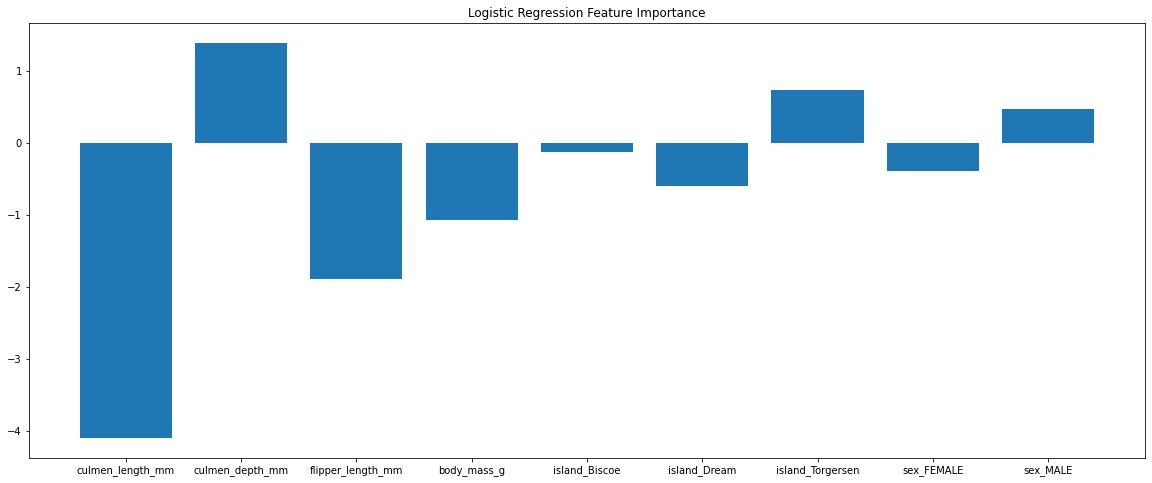

In [988]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
importance = lr_model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(20,8))
plt.bar([x for x in X_train.columns], importance)
plt.title('Logistic Regression Feature Importance')
plt.show()

Feature: 0, Score: 0.19602
Feature: 1, Score: 0.03472
Feature: 2, Score: 0.39476
Feature: 3, Score: 0.00335
Feature: 4, Score: 0.00913
Feature: 5, Score: 0.21077
Feature: 6, Score: 0.14138
Feature: 7, Score: 0.00552
Feature: 8, Score: 0.00435


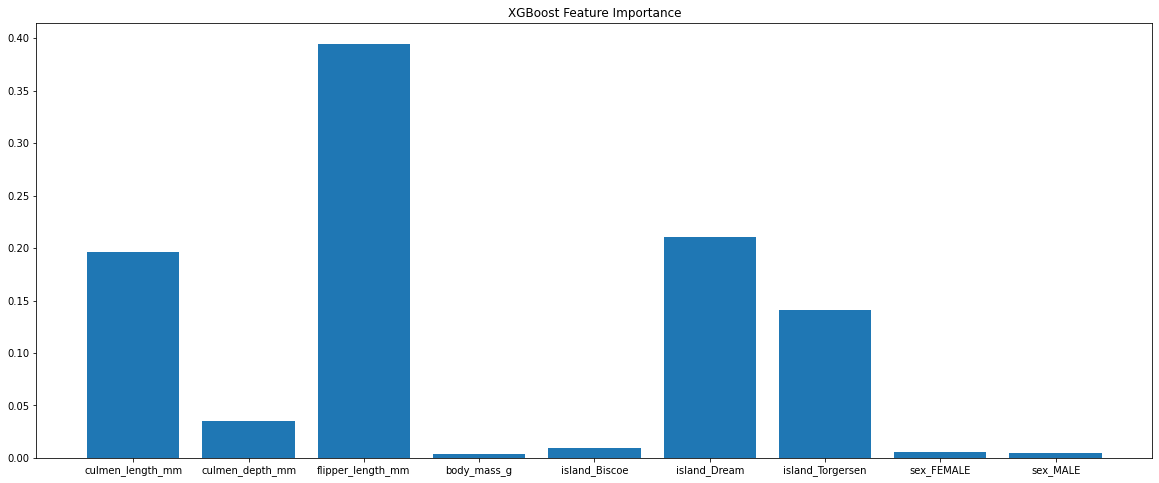

In [989]:
xgb_model = XGBClassifier()
# fit the model
xgb_model.fit(X_train, y_train)
# get importance
importance = xgb_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(20,8))
plt.bar([x for x in X_train.columns], importance)
plt.title('XGBoost Feature Importance')
plt.show()
print()

In [990]:
feature_importances = pd.DataFrame([xgb_model.feature_importances_], columns=X_train.columns)
feature_importances

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE
0,0.196015,0.034725,0.394756,0.003353,0.009131,0.210775,0.141376,0.005521,0.004348


##### Review ROC Curves

###### Resources

[TDS ROC Curves for MultiClass](https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a)

[Associated Github Notebook](https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb)

###### Methods

In [991]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [992]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [993]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [1007]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])
classes_combinations

[['Adelie', 'Chinstrap'],
 ['Chinstrap', 'Adelie'],
 ['Adelie', 'Gentoo'],
 ['Gentoo', 'Adelie'],
 ['Chinstrap', 'Gentoo'],
 ['Gentoo', 'Chinstrap']]

###### ROC Curves One vs Rest

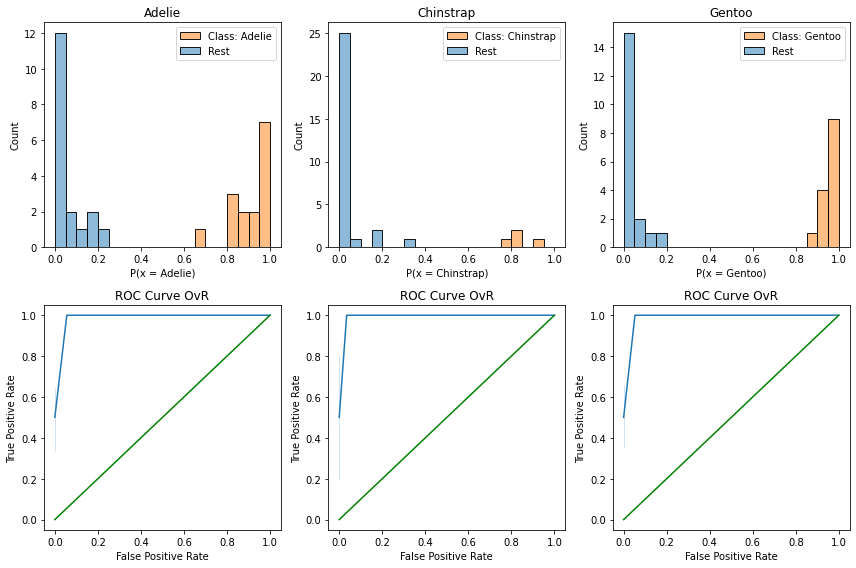

In [1009]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = lr_model.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = lr_model.predict_proba(X_test)[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

In [1003]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

Adelie ROC AUC OvR: 1.0000
Chinstrap ROC AUC OvR: 1.0000
Gentoo ROC AUC OvR: 1.0000
average ROC AUC OvR: 1.0000


###### ROC Curves One vs. One

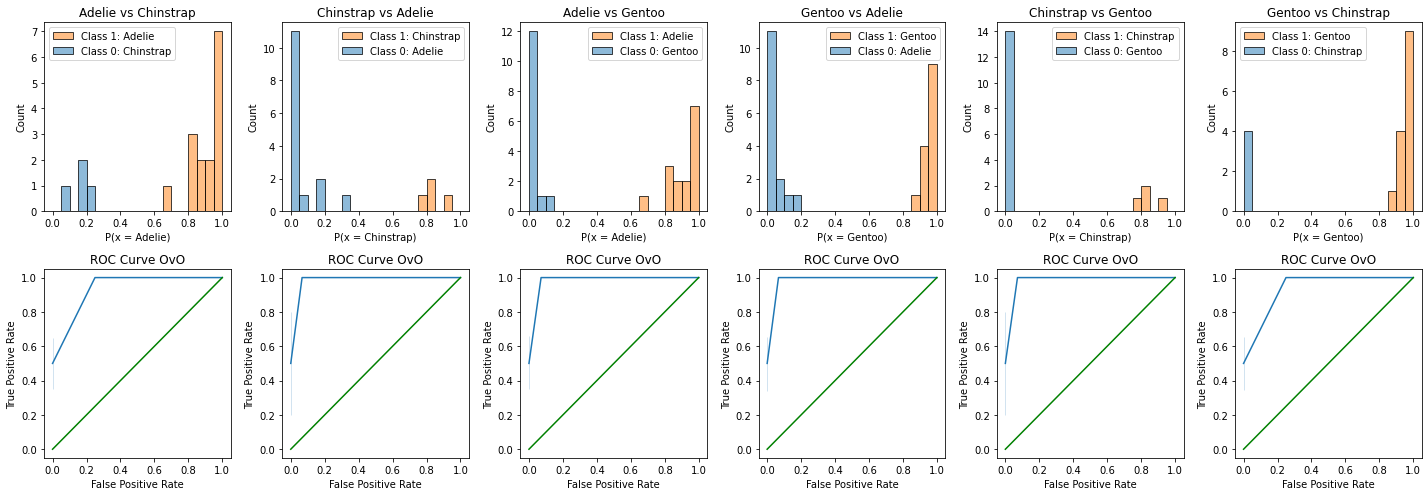

In [1010]:
# Plots the Probability Distributions and the ROC Curves One vs ONe
plt.figure(figsize = (20, 7))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = c1 + " vs " +c2
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = lr_model.predict_proba(X_test)[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 6, i+7)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

In [1011]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

Adelie vs Chinstrap ROC AUC OvO: 1.0000
Chinstrap vs Adelie ROC AUC OvO: 1.0000
Adelie vs Gentoo ROC AUC OvO: 1.0000
Gentoo vs Adelie ROC AUC OvO: 1.0000
Chinstrap vs Gentoo ROC AUC OvO: 1.0000
Gentoo vs Chinstrap ROC AUC OvO: 1.0000
average ROC AUC OvO: 1.0000


### Regression

In [996]:
# precision, recall, _ = precision_recall_curve(y_val, baseline_model.decision_function(X_val))
# plt.plot(recall, precision, 'b-')
# precision, recall, _ = precision_recall_curve(y_val, best_model.decision_function(X_val))
# plt.plot(recall, precision, 'r-')
# plt.title("Precision-Recall curve")
# plt.show()

## Discussion

### Classification

#### Best current model

In [997]:
model_tracker.sort_values(by=["train_or_test", "accuracy"], ascending=False)

,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,KNeighborsClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,SGDClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,MLPClassifier(),validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,"GridSearchCV(estimator=LogisticRegression(),\n...",validate,X_val,1.000000,1.000000,1.000000,1.000000,"[[16, 0, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,LogisticRegression(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,RidgeClassifier(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,DecisionTreeClassifier(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,BaggingClassifier(base_estimator=KNeighborsCla...,validate,X_val,0.968750,0.971875,0.968750,0.969068,"[[15, 1, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,BaggingClassifier(base_estimator=SVC()),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,BaggingClassifier(base_estimator=DecisionTreeC...,validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None


#### Error Analysis

##### Compare Predicted Labels to Actual Labels

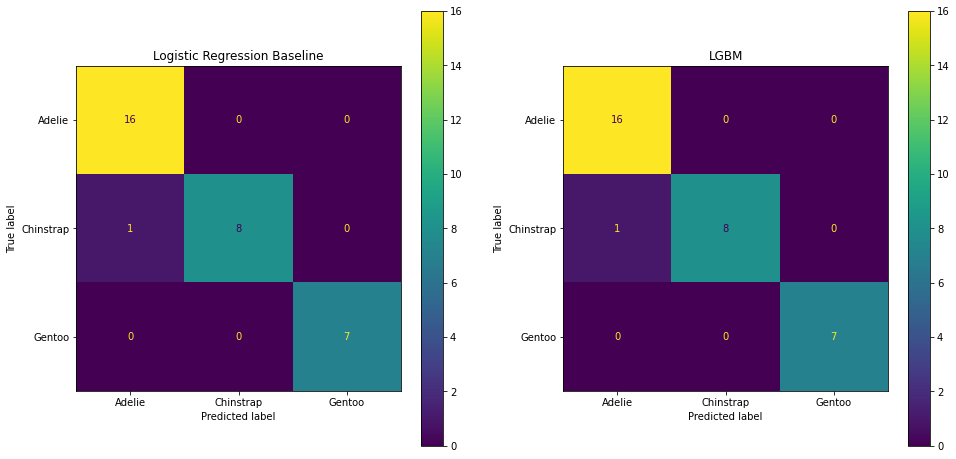

In [999]:
fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(16, 8))
ConfusionMatrixDisplay.from_estimator(lr_model, X_val, y_val, ax=axs1)
ConfusionMatrixDisplay.from_estimator(xgb_model, X_val, y_val, ax=axs2)
axs1.set_title("Logistic Regression Baseline")
axs2.set_title("LGBM")
plt.show()

### Recommendations for Future Work

## Research Journal

### Data-Centric Iteration Ideas


### Model-Centric Iteration Ideas

### Improvements to the Template

- allow comments on models
- send the train / test / split as a dictionary
- add feature ablation by feature importance
- training time tracking
- distinguish between binary and multi-class classification
- KFold

### Daily Log